In [1]:
using LinearAlgebra
using SparseArrays
using Plots
using LaTeXStrings
using DelimitedFiles
using Polynomials
using Statistics
fnt = Plots.font("sans-serif", 15) # Para gráficar loas labels


Plots.Font("sans-serif", 15, :hcenter, :vcenter, 0.0, RGB{N0f8}(0.0,0.0,0.0))

In [2]:
#Nos busca un indice k tal que los numeros posteriores son 0
#k=3 si |2,1,0,0,0> 
function search_k(M::Int64,n::Vector{Int64})
    k=1 #iniciamos en la pos 1
    for i=1:M #Recorreremos todas las posisiciones M para checar las j>i
        k=i #Nuestro primer prospecto a ser j
        flag=0 #Definimos una bandera si es
                # 1--> significa que encontro una n_{j} tal que los de adelante son 0
                #0--> no lo ha encontrado
        for j=k+1:M-1 #Revisaremos los n_{j} j>i si son cero
            if n[j]!=0 # si encientra una n_{j}!=0
                break  # ya no revises más
            elseif (j == M-1) # si j llega al penultimo valor entonces
                flag=1 # ya lo encontró
            end
        end
        if flag==1 # si la bandera es 1, ya encontro la k
            k=i # entonces esa i es la k
            break # ya no hace falta revisar más
        end
    
    if k==M # si no encontro ningun valor entonces signfica que tomaremos el penultimo valor
        k=M-1
    end
        
    end
    
    return k
end

function base_fock(N::Int64,M::Int64)
    D=binomial(N+M-1,N) #declaramos la variable de la dimension del espacio de Hilbert
    DM=zeros(Int64,(D,M)) #Aquí se colocaran las bases
    n=zeros(Int64,M) #Este vector va a ser el que modificaremos y usaremos para sobre escribir cada fila de DM
    
    DM[1,1]=N #El primer estado de la base
    n[1]=N    # Coincidde con el estado base
    
    l=1 # es un contador para colocar los demas estados
     #k es el indice donde despues de ese todos son ceros
    
    while n[M]!=N
        l+=1 #incrementamos el contador
        k=search_k(M,n) #buscamos la k
        n[k]=n[k]-1 #Primer paso del cambio n_{k}=n_{k}-1
        #Compienza el segundo paso de la suma n_{k+1}=n_{k}-1
        n[k+1]=N

        for i=1:k
            n[k+1]=n[k+1]-n[i]
        end
        #Cambiamos por ceros los n_{i} tales que i>=k+2
        for i=k+2:M
            n[i]=0
        end
        #Agregamos el estado n a la fila l
        DM[l,:]=n
    end
    
    
    return DM;
    
end

# Operadores de Hamiltoniano
function ascenso_mu(mu::Int64, N::Int64,vector_base::Vector{Int64})
    part=vector_base[mu]+1
    norm=sqrt(vector_base[mu]+1)
    if part>N
        norm=0.0
    end
    vector_base[mu]=part
    return norm;
end

function descenso_mu(mu::Int64, N::Int64,vector_base::Vector{Int64})
    
    part=vector_base[mu]-1
    if vector_base[mu]<0
        norm=0.0
    else
        norm=sqrt(vector_base[mu])
    end
    
    if part<0
        norm=0.0
    end
    vector_base[mu]=part
    return norm;
end

function Numero_mu(mu::Int64, N::Int64,vector_base::Vector{Int64})
    return vector_base[mu];
end

##//Funcion para localizar vectores base//////////
function Buscador(vector_base::Vector{Int64},N::Int64,M::Int64)

    i0=N #indice para ayudarnos a que este fijo el num de particulas disponibles
    i1=0 #indice para ayudarnos a restar
    Sitios=2 #Numero de sitios que se quitan +1 (al principio se quita un sitio por eso es 2)

    contador=1

    for j=1:M
        while i0-i1 != vector_base[j]
            contador=contador+binomial(M-Sitios+i1,i1)
            i1+=1
        end
        i0=i1
        i1=0
        Sitios+=1
    end

    return contador
end

# Base extendida
function base_2_ex(N::Int64)
    base_2_extendida=zeros(Int64,((N+1)^2,2))
    l=1
    for i=0:N
        for j=0:N
            base_2_extendida[l,:]=[i,j]
            l=l+1
        end
    end
    return base_2_extendida
end

# base_2_extendida=base_2_ex(N)

function buscador_ext_bas(vector_base_ext::Vector{Int64},N::Int64)
    return ( vector_base_ext[1]*(N+1) )+1 +vector_base_ext[2]
end


buscador_ext_bas (generic function with 1 method)

In [3]:
#Hamiltoniano Cinético at_{m}*a_{m+1} + at_{m+1}*a_{m}
function H_J(J::Float64,N::Int64,M::Int64,D::Int64,bases::Matrix{Int64})
    H=zeros(D,D)
    #Esta es la parte     at_{m}*a_{m+1} + at_{m+1}*a_{m}
    for l=1:D #Usaremos cada elemento de la base
        for mu=1:M #Recorreremos cada sitio del elemento de la base
            n=bases[l,:] #Es el vector con el que se trabajara
            #Aplicamos las condiciones de frontera periodicas ANILLO
            if mu==M
                a=descenso_mu(1,N,n)
                at=ascenso_mu(mu,N,n)
            else
                a=descenso_mu(mu+1,N,n)
                at=ascenso_mu(mu,N,n)
            end
            if at*a != 0
                col=Buscador(n,N,M)
                H[col,l]=H[col,l]-J*at*a
                H[l,col]=H[l,col]-J*at*a
            end

        end
    end
    return H
end



#Esta es la parte     at_{mu}*n_{mu+nu}*a_{m+1} + at_{mu+1}*n_{mu+nu}*a_{m}
function H_K1(K1::Float64,N::Int64,M::Int64,D::Int64,bases::Matrix{Int64})
    H=zeros(D,D)
    #Esta es la parte     at_{m}*a_{m+1} + at_{m+1}*a_{m}
    for l=1:D #Usaremos cada elemento de la base
        for mu=1:M #Recorreremos cada sitio del elemento de la base
            for nu=0:1 #esto es para el operador de numero n_{mu+nu}
                n=bases[l,:] #Es el vector con el que se trabajara
                #Aplicamos las condiciones de frontera periodicas ANILLO
                if mu==M && nu==1
                    a=descenso_mu(1,N,n)
                    num=Numero_mu(1,N,n)
                    at=ascenso_mu(mu,N,n)
                elseif mu==M && nu==0
                    a=descenso_mu(1,N,n)
                    num=Numero_mu(mu,N,n)
                    at=ascenso_mu(mu,N,n)
                else
                    a=descenso_mu(mu+1,N,n)
                    num=Numero_mu(mu+nu,N,n)
                    at=ascenso_mu(mu,N,n)
                end
                if at*a*num != 0
                    col=Buscador(n,N,M)
                    H[col,l]=H[col,l]-K1*at*a*num
                    H[l,col]=H[l,col]-K1*at*a*num
                end
            end
        end
    end
    return H
end


#Esta es la parte  at_{m}*at_{m}*a_{m+1}*a_{m+1} + at_{m+1}*at_{m+1}*a_{m}*a_{m}
function H_K2(K2::Float64,N::Int64,M::Int64,D::Int64,bases::Matrix{Int64})
    H=zeros(D,D)
    #Esta es la parte     at_{m}*a_{m+1} + at_{m+1}*a_{m}
    for l=1:D #Usaremos cada elemento de la base
        for mu=1:M #Recorreremos cada sitio del elemento de la base
            n=bases[l,:] #Es el vector con el que se trabajara
            #Aplicamos las condiciones de frontera periodicas ANILLO
            if mu==M
                a=descenso_mu(1,N,n)
                a=a*descenso_mu(1,N,n)
                at=ascenso_mu(mu,N,n)
                at=at*ascenso_mu(mu,N,n)
            else
                a=descenso_mu(mu+1,N,n)
                a=a*descenso_mu(mu+1,N,n)
                at=ascenso_mu(mu,N,n)
                at=at*ascenso_mu(mu,N,n)
            end

            if at*a != 0
                col=Buscador(n,N,M)
                H[col,l]=H[col,l]-K2*at*a
                H[l,col]=H[l,col]-K2*at*a
            end
        end
    end
    return H
end

#Esta es la parte  at_{m}*at_{m}*a_{m+1}*a_{m+1} + at_{m+1}*at_{m+1}*a_{m}*a_{m}
function H_U(U::Float64,N::Int64,M::Int64,D::Int64,bases::Matrix{Int64})
    H=zeros(D,D)
    for l=1:D #Usaremos cada elemento de la base
        n=bases[l,:] #Es el vector con el que se trabajara
        for i=1:M
            H[l,l]=H[l,l]+U*0.5*(n[i]*(n[i]-1))
        end
    end
    return H

end


#El hamiltoniano es H = H_J + H_K1 + H_K2 + H_U

H_U (generic function with 1 method)

In [4]:
## Se evoluciona con los eigen valores

U_tempo(t)=exp.(-im*evals*t)

#Hay que hace una función con la condicion incial en E con evolución temporal U(t)
function Edo_evol_E(Vector_0, Evol_temp)
    Result=zeros(Complex{Float64},D)
    for i=1:D
        Result[i]=Vector_0[i]*Evol_temp[i]
    end
    return Result
end

function rho_c_reducida_ex(n_nu::Int64,n_mu::Int64,N::Int64,D::Int64,
                                bases::Matrix{Int64},base_2_extendida::Matrix{Int64},rho_c::Matrix{ComplexF64},T=false)
   
    rho_c_reducida_exten=zeros(ComplexF64,((N+1)^2,(N+1)^2))

    ### Revisamos cada uno de los elemtnos de la base extendida |n_{\nu}^{i},n_{\mu}^{i}><n_{\nu}^{j},n_{\mu}^{j}|
    for i=1:(N+1)^2
        for j=1:(N+1)^2
            #### Esta es la primera delta de dirac (conservacion de particulas en la traza) --->
            ####  ---> \delta_{ n_{\nu}^{i}+n_{\mu}^{i} , n_{\nu}^{j}+n_{\mu}^{j} }
            if sum(base_2_extendida[i,:])==sum(base_2_extendida[j,:])
                #println(sum(base_2_extendida[i,:]), sum(base_2_extendida[j,:]))
                ### Aqui es la segunda delta de dirac (Conservacion de particulas sin traza) --->
                ### ----->\delta_{n_{1}^{i}+n_{2}^{i}+...+n_{M}^{i}} , N}
                for k=1:D #Tecnicamente ya sabemos quienes cumplen eso son los de la base de fock
                    # Reviamos que elementos de la base de fock tienen n_{\nu}^{i} y n_{\mu}^{i} simultaneamente de la base extendida para i
                    # el k-esimo elemento es <k|\rho(t)| NOSE >
                    if bases[k,:][n_nu]==base_2_extendida[i,1] && bases[k,:][n_mu]== base_2_extendida[i,2] 
                        #println(i," ",j," ",base_2_extendida[i,:], " ", base_2_extendida[j,:])
                        #falta construir el NOSE que se compone de |n_{}^{i}...n_{\nu}^{j}...n_{\mu}^{j}>
                        #Con el <k| coinciden los que no son n_{\nu}^{j} n_{\mu}^{j}, entonces
                        NOSE=bases[k,:]
                        NOSE[n_nu],NOSE[n_mu]=base_2_extendida[j,:][1],base_2_extendida[j,:][2]
                        #println(Buscador(bases[k,:],N,M), " ", Buscador(NOSE,N,M))
                        rho_c_reducida_exten[i,j]+=rho_c[Buscador(bases[k,:],N,M),Buscador(NOSE,N,M)]
                        #println("En en la entrada "*L"|",base_2_extendida[i,:],L"\rangle\langle",base_2_extendida[j,:],L"|"*"Entre!")
                    end

                end

            else
                #println(0)
            end

        end
    end
    
    if T==false
        return rho_c_reducida_exten #<----------------------Resultado
    else
        rho_c_reducida_exten_trans_par=zeros(ComplexF64,((N+1)^2,(N+1)^2))
        ## Vamos a recorer cada elemento de la matriz de densidad reducida para transponerla
        for i=1:(N+1)^2
                for j=1:(N+1)^2
                ### Trasnponemos |n_{\nu}^{i},n_{\mu}^{i}><n_{\nu}^{j},n_{\mu}^{j}| --->
                ###     ------>  |n_{\nu}^{i},n_{\mu}^{j}><n_{\nu}^{j},n_{\mu}^{i}|
                Transpo1=buscador_ext_bas( [base_2_extendida[i,:][1], base_2_extendida[j,:][2]] ,N)
                Transpo2=buscador_ext_bas( [base_2_extendida[j,:][1], base_2_extendida[i,:][2]] ,N)
                
                rho_c_reducida_exten_trans_par[Transpo1,Transpo2]=rho_c_reducida_exten[i,j]
                #println(i-1,",",j-1,"--->",Transpo1-1,",",Transpo2-1)
            end
        end
        return rho_c_reducida_exten_trans_par#<----------------------Resultado
    end
    
end


rho_c_reducida_ex (generic function with 2 methods)

In [42]:
N=1
M=5
D=binomial(N+M-1,N)
bases=base_fock(N,M)
bases

3×3 Matrix{Int64}:
 1  0  0
 0  1  0
 0  0  1

In [66]:
J=1.0
K1=0.0
K2=0.0
U=1.0

# tenemos que escoger con que los nos n_[\nu] y n_{\mu} para trazar sobre los otros.
n_nu=3
n_mu=2

# tiempo
dt=0.01
Time_0=0
Time_f=10
times=Time_0:dt:Time_f

# Condicion inicial, puede ser localizada
Vector_0_F=zeros(D) 
Vector_0_F[1]=1
#Vector_0_F[2]=1/sqrt(2)

bases=base_fock(N,M)
base_2_extendida=base_2_ex(N) #BAses para dos sitios extendida


# Hamiltoniano

H=H_J(J,N,M,D,bases)+H_U(U,N,M,D,bases) #+H_K1(J,N,M,D,bases) + H_K2(J,N,M,D,bases)

Change_E_F=eigvecs(H) # MAtriz cambio de base de Energias a Fock
Change_F_E=transpose(Change_E_F) # MAtriz cambio de base de Fock a Energias

# Hay que hacerel cambio de base antes de hacer la evolución temporal
Vector_0_E=Change_F_E*Vector_0_F

#Para la evolcución temporal necesitamos los eigenvalores
evals=eigvals(H)


## AQUI EMPIEZA LA DINAMICA## NEGATIVIDAD
DATA_N=zeros(length(times))
#How_many=zeros(length(times))
for (index,t) in enumerate(times)
    Edo_F_t=Change_E_F*Edo_evol_E(Vector_0_E, U_tempo(t)) #<--- Aqui evoluciona el tiempo


    #print(t)
    #display(Edo_F_t)
    #HAcemos la matriz de densidad
    rho_c=Edo_F_t*transpose(conj(Edo_F_t))
#         if index==10
#             display(Edo_F_t)
#         end
    Eva=eigvals(rho_c_reducida_ex(n_nu,n_mu,N,D,bases,base_2_extendida,rho_c,true))
    Negativity=0
    #MANY=0
    for i in Eva
        if i<0
            #MANY+=1
            Negativity=Negativity+abs(i)
        end
    end
    #How_many[index]=MANY
    DATA_N[index]=Negativity
end

In [67]:
#Parte analítica para 1 boson

N_list_ana=zeros(length(times))
C_list_ana=zeros(length(times))
for j=1:length(times)
    Vector_psi_t=Change_E_F*Edo_evol_E(Vector_0_E, U_tempo(times[j])) #Vector |\psi(t)>

    Vector_psi_t_2=abs2.(Vector_psi_t)  #Modulos al cuadrado  de cada uno
    #Las gamas de los sitios de interes
    gamma_nu_2=Vector_psi_t_2[n_nu]   #Modulos al cuadrado de nu y mu
    gamma_mu_2=Vector_psi_t_2[n_mu]

    #sumar los modulos al cuadrado 
    sum_gamas_2=0.0
    for i=1:M
        if i==n_nu || i==n_mu
            sum_gamas_2+=0
        else
            sum_gamas_2+=Vector_psi_t_2[i]
        end
    end
    
    C_list_ana[j]=2*sqrt(gamma_nu_2*gamma_mu_2)
    N_list_ana[j]=0.5*(sum_gamas_2-sqrt(sum_gamas_2^2+4*gamma_nu_2*gamma_mu_2))
end
N_list_ana=abs.(N_list_ana);

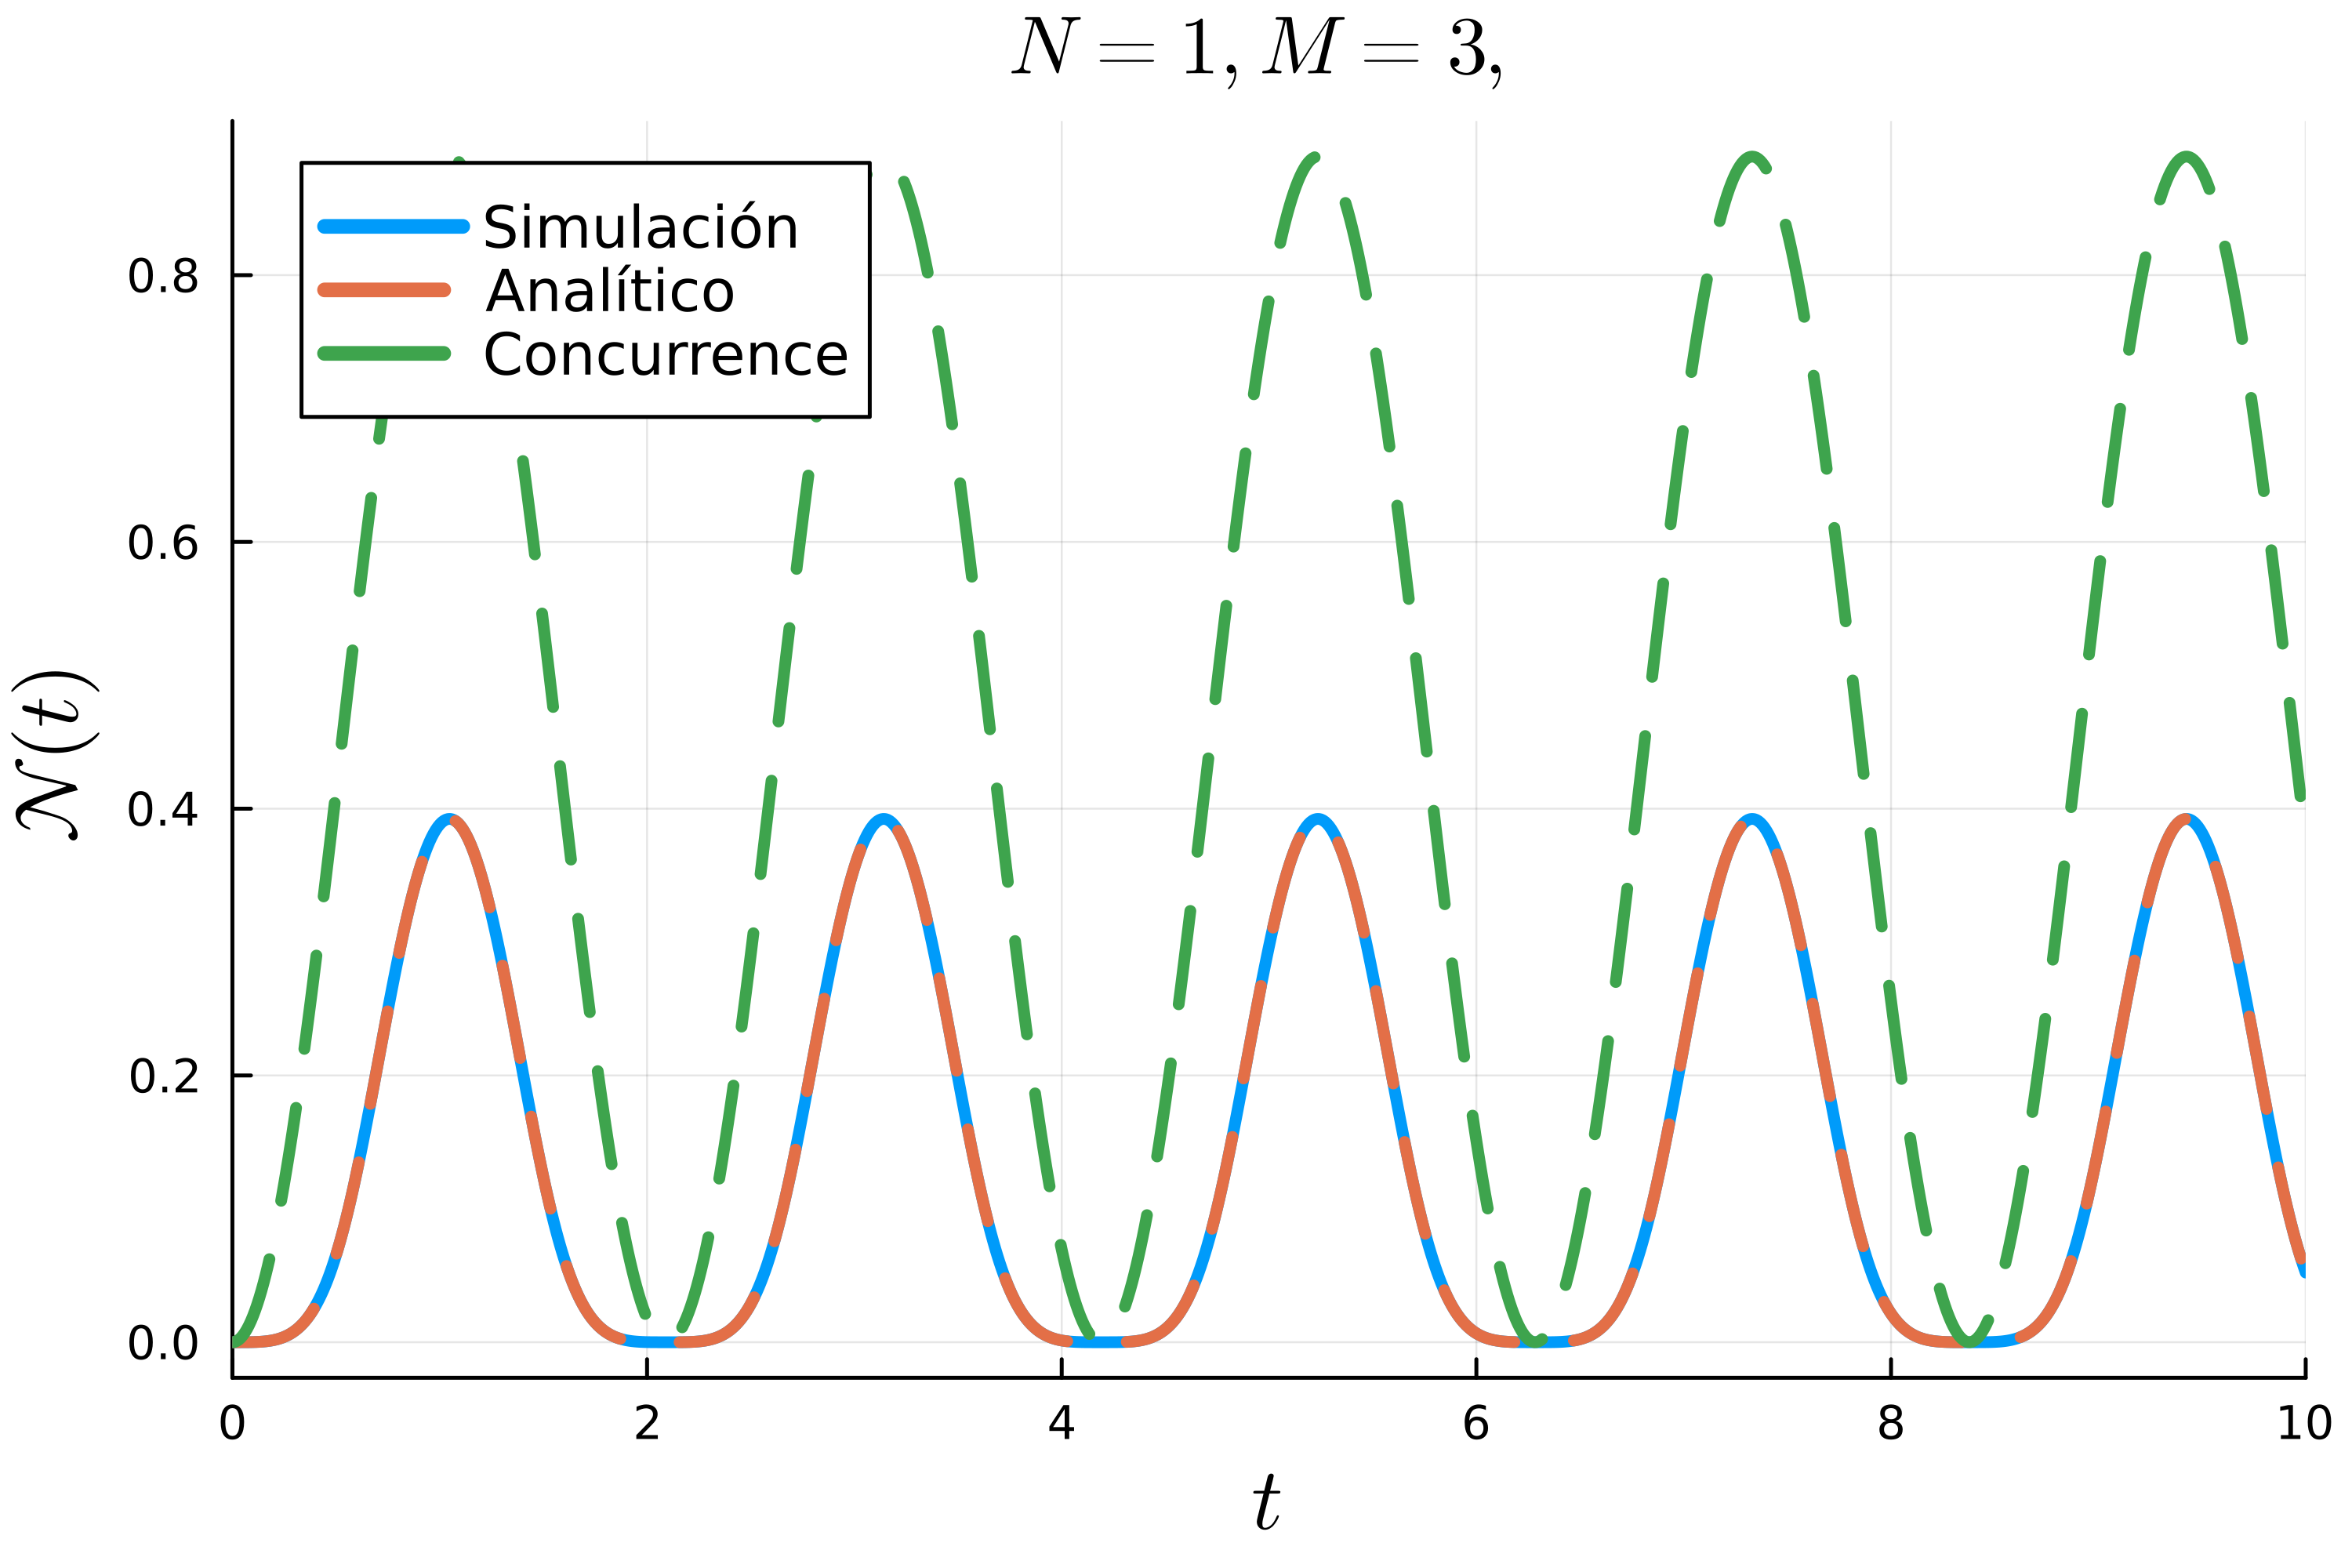

In [68]:
plot(times,DATA_N,guidefont=fnt, fmt = :png, dpi=500.,
    title=L"N=%$N, M=%$M, ",#L", M="*latexstring(M)*L", N="*latexstring(N)*L", \nu="*latexstring(n_nu)*L", \mu="*latexstring(n_mu),
    label="Simulación",
    ylabel=L"\mathcal{N}(t)",xlabel=L"t",
    linestyle=:solid,lw=3,legend=:best,legendfontsize=10,
    xlims=(0,10))
plot!(times,N_list_ana,label="Analítico",lw=3,linestyle=:dash)
plot!(times,C_list_ana,label="Concurrence",lw=3,linestyle=:dash)

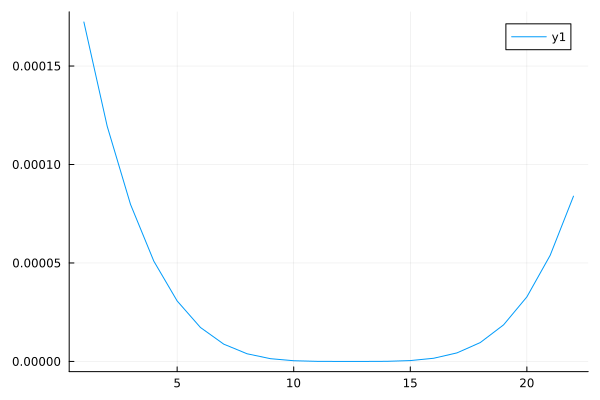

In [92]:
plot(DATA_N[199:220])

In [81]:
times[201]

2.0